In [4]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import sklearn
from sklearn.externals import joblib

import gplearn as gp
from gplearn.genetic import SymbolicRegressor

In [2]:
# load neuravi
import neuravi

### Load dataset
ds = neuravi.data_loader("./data/DataSet_0p20val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5","cpu")

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [3]:
X_ = ds.x_entro_train.detach().numpy()
y_ = ds.y_entro_train.detach().numpy()

In [40]:
def _mixing(x1, x2):
    x1l = x1.copy()*0.0
    x1l[x1>0] = x1[x1>0]*np.log(x1[x1>0])
    x2l = x2.copy()*0.0
    x2l[x2>0] = x2[x2>0]*np.log(x2[x2>0])
    return -8.314*(x1l+x2l)

mixing = gp.functions.make_function(function=_mixing,
                        name='mixing',
                        arity=2)

In [46]:

est_gp = SymbolicRegressor(function_set=('add', 'sub', 'mul', 'div',mixing),
                           population_size=5000,
                           generations=20, stopping_criteria=0.0001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_, y_)

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    31.98      2.31039e+06       21          2.05395           1.9854     49.43s
   1    13.06          82.1115       29          1.32974           1.5583     30.83s
   2    16.66           112.26       19          1.22825          1.29339     36.36s
   3    19.48          22.8472       23          1.07929          1.09566     32.63s
   4    21.00           13.151       23         0.912591         0.963353     31.73s
   5    23.19          24.3142       31         0.861262         0.765101     31.03s
   6    22.37          32.8847       31         0.851747         0.850737     31.70s
   7    22.86          19.5289       31         0.829311          1.05266     25.36s
   8    22.19          78.8399       31         0.816303         0.975333  

SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div',
                                <gplearn.functions._Function object at 0x7fb8f58924d0>),
                  generations=20, init_depth=(2, 6),
                  init_method='half and half', low_memory=False,
                  max_samples=0.9, metric='mean absolute error', n_jobs=1,
                  p_crossover=0.7, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_point_replace=0.05, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.0001, tournament_size=20,
                  verbose=1, warm_start=False)

In [47]:
print(est_gp._program)

sub(sub(mixing(X2, X2), div(add(X2, X1), add(add(X0, X2), sub(X3, X0)))), mixing(add(X0, -0.907), add(add(X0, X3), add(X0, X3))))


In [43]:
X_test = ds.x_entro_test.detach().numpy()
y_test = ds.y_entro_test.detach().numpy()

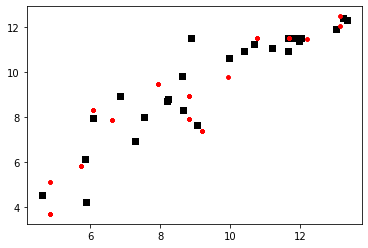

In [44]:
plt.plot(y_, est_gp.predict(X_),"ks")
plt.plot(y_test,  est_gp.predict(X_test),"r.")

<ErrorbarContainer object of 3 artists>

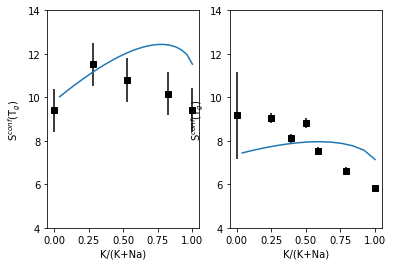

In [45]:
na2o = np.arange(0.,0.25,0.01)
k2o = 0.25-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.zeros(len(na2o))

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.subplot(1,2,1)
plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),est_gp.predict(X_visu_),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

plt.subplot(1,2,2)
na2o = np.arange(0.,0.125,0.01)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),est_gp.predict(X_visu_),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="ks",
    label="Le Losq et al., 2017")

In [13]:
est_gp.warm_start = True
est_gp.stopping_criteria=0.001
est_gp.fit(X_, y_)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/gplearn/genetic.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new programs.
  warn('Warm-start fitting without increasing n_estimators does not '


SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div',
                                <gplearn.functions._Function object at 0x7fb8f7f812d0>),
                  generations=20, init_depth=(2, 6),
                  init_method='half and half', low_memory=False,
                  max_samples=0.9, metric='mean absolute error', n_jobs=1,
                  p_crossover=0.7, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_point_replace=0.05, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.001, tournament_size=20,
                  verbose=1, warm_start=True)